In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb

In [2]:
train=pd.read_csv('Train')
test=pd.read_csv('test')

In [3]:
target_col = 'consumption'
feature_cols = [col for col in train.columns if col != target_col]

# Extract features from training set
X_train = train[feature_cols]

# Extract target from training set
y_train = train[target_col]

# Extract features from test set
X_test = test[feature_cols]

# Extract target from test set
y_test = test[target_col]

In [4]:
seq_length = 24

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [6]:
X_train_lstm = []
y_train_lstm = []

In [9]:
from sklearn.preprocessing import StandardScaler
scaler_lstm=StandardScaler()

In [11]:
train_scaled = scaler_lstm.fit_transform(train[['consumption']])

In [12]:
test_scaled = scaler_lstm.transform(test[['consumption']])

In [13]:
for i in range(len(train_scaled) - seq_length):
        # Append sequence of length seq_length as input
        X_train_lstm.append(train_scaled[i:i + seq_length])
        # Append next value as target (what we want to predict)
        y_train_lstm.append(train_scaled[i + seq_length])

In [14]:
X_train_lstm = np.array(X_train_lstm)
y_train_lstm = np.array(y_train_lstm)

In [15]:
X_test_lstm = []
y_test_lstm = []

In [16]:
for i in range(len(test_scaled) - seq_length):
        # Append sequence of length seq_length as input
        X_test_lstm.append(test_scaled[i:i + seq_length])
        # Append next value as target
        y_test_lstm.append(test_scaled[i + seq_length])

In [18]:
X_test_lstm = np.array(X_test_lstm)
y_test_lstm = np.array(y_test_lstm)
    
# Print shapes of created sequences
print(f"X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_lstm shape: {y_train_lstm.shape}")
print(f"X_test_lstm shape: {X_test_lstm.shape}")
print(f"y_test_lstm shape: {y_test_lstm.shape}")

X_train_lstm shape: (28028, 24, 1)
y_train_lstm shape: (28028, 1)
X_test_lstm shape: (6989, 24, 1)
y_test_lstm shape: (6989, 1)


In [21]:
lstm_model=Sequential(
)

In [27]:
# ✅ CORRECT - First LSTM returns sequences
lstm_model = Sequential()

# First LSTM layer - returns 3D output (batch, time_steps, 64)
lstm_model.add(LSTM(64, activation='relu', return_sequences=True,
                    input_shape=(seq_length, 1)))

lstm_model.add(Dropout(0.2))

# Second LSTM layer - receives 3D input, returns 2D output
lstm_model.add(LSTM(64, activation='relu', return_sequences=True))  # or just default
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32, activation='relu'))
lstm_model.add(Dropout(0.2))

# Dense output layer
lstm_model.add(Dense(1))

In [28]:
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [29]:
lstm_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,369 (243.63 KB)

 Trainable params: 62,369 (243.63 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, 
                               restore_best_weights=True)

In [34]:
checkpoint = ModelCheckpoint('Checkpoints.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [35]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.001)

In [ ]:
history = lstm_model.fit(
        X_train_lstm, y_train_lstm,  # Training data (sequences and targets)
        epochs=50,  # Maximum number of training iterations through full dataset
        batch_size=32,  # Number of samples per gradient update
        validation_split=0.1,  # Use 10% of training data for validation
        callbacks=[early_stop,checkpoint,reduce_lr],  # Apply early stopping to prevent overfitting
        verbose=1  # Show progress bar during training
    )

Epoch 1/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - loss: 0.3550 - mae: 0.3459 - val_loss: 0.0928 - val_mae: 0.1515 - learning_rate: 0.0010
Epoch 2/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.2299 - mae: 0.2630 - val_loss: 0.0803 - val_mae: 0.1335 - learning_rate: 0.0010
Epoch 3/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.2083 - mae: 0.2433 - val_loss: 0.0847 - val_mae: 0.1412 - learning_rate: 0.0010
Epoch 4/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.2016 - mae: 0.2357 - val_loss: 0.0815 - val_mae: 0.1373 - learning_rate: 0.0010
Epoch 5/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.1939 - mae: 0.2311 - val_loss: 0.0780 - val_mae: 0.1346 - learning_rate: 0.0010
Epoch 6/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.1940 - mae: 0.2266 - val_loss: 0.0773 - val_mae: 0.1336 - learning_rate: 0.0010
Epoch 7/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.1858 - mae: 0.2232 - val_loss: 0.0832 - val_mae: 0.1421 - learning_rate:

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [46]:
predictions_scaled = lstm_model.predict(X_test_lstm, verbose=0)
lstm_pred = scaler_lstm.inverse_transform(predictions_scaled)

lstm_pred = lstm_pred.flatten()
lstm_actual = test['consumption'].values[seq_length:]

lstm_mae = mean_absolute_error(lstm_actual, lstm_pred)
print(lstm_mae)

1.1295466798179945


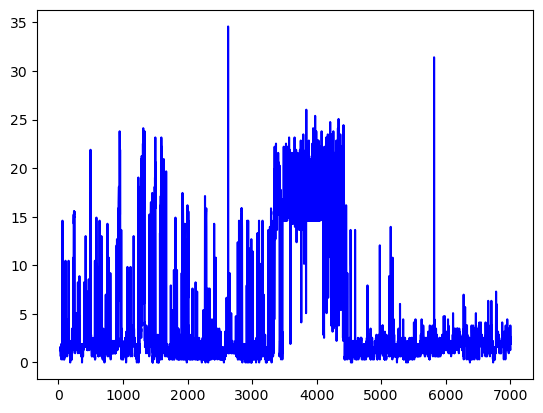

In [43]:
test_subset = test.iloc[seq_length:]
plt.plot(test_subset.index, test_subset['consumption'],
        label='Actual', linewidth=1.5, color='blue')

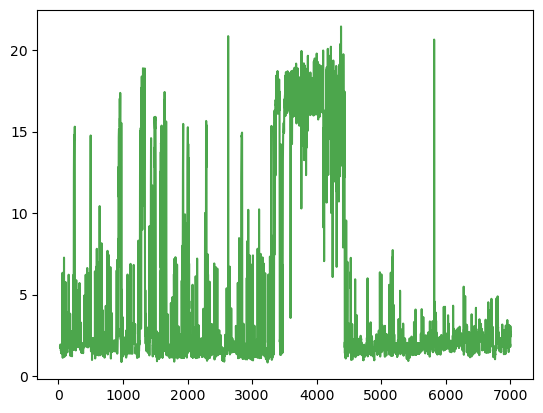

In [44]:
plt.plot(test_subset.index, lstm_pred,
        label='LSTM Predicted', linewidth=1.5, alpha=0.7, color='green')


In [49]:
model.save('lstm_model.keras')